Classification Report:
              precision    recall  f1-score   support

           2       0.87      0.87      0.87      2433
           3       0.85      0.86      0.86      2352
           4       0.87      0.85      0.86      2405

    accuracy                           0.86      7190
   macro avg       0.86      0.86      0.86      7190
weighted avg       0.86      0.86      0.86      7190



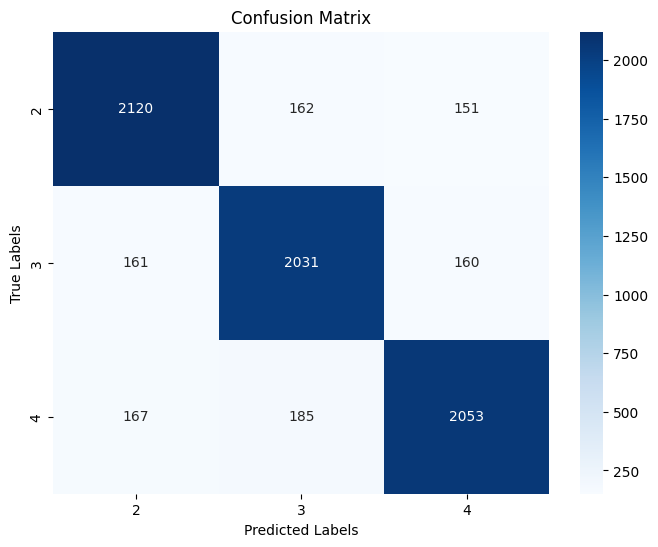

Validation Accuracy: 0.86
Submission saved successfully!


In [11]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Data Loading
transactions = pd.read_csv('transactions.csv', parse_dates=['purchase_date'])
product_catalog = pd.read_csv('product_catalog.csv')
product_category_map = pd.read_csv('product_category_map.csv')
test_df = pd.read_csv('test.csv')

# Convert date to datetime and create additional time-based features
transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])
transactions['year_month'] = transactions['purchase_date'].dt.to_period('M')

# Explode categories in product_catalog
product_catalog['categories'] = product_catalog['categories'].apply(lambda x: eval(x) if pd.notnull(x) else [])
product_catalog_exploded = product_catalog.explode('categories').rename(columns={'categories': 'category_id'})

# Merge product attributes and category info
merged_catalog = product_catalog_exploded.merge(product_category_map, on='category_id', how='left')
merged_catalog = merged_catalog.drop_duplicates(subset=['product_id'], keep='first')

# Merge transactions with product info
merged_data = transactions.merge(
    merged_catalog.drop(columns=['category_id', 'parent_category_id']),
    on='product_id', how='left'
)

# Encode categorical features
for col in ['attribute_1', 'attribute_2', 'attribute_3', 'attribute_4', 'attribute_5']:
    if col in merged_data.columns:
        merged_data[col], _ = pd.factorize(merged_data[col].fillna('Unknown'), sort=True)

if 'manufacturer_id' in merged_data.columns:
    merged_data['manufacturer_id'], _ = pd.factorize(merged_data['manufacturer_id'].fillna(-1), sort=True)

# Feature creating with sliding window approach
def create_features_target(data, start_date, window_size=28):
    start_date = pd.to_datetime(start_date)
    end_date = start_date + timedelta(days=window_size)
    next_period_start = end_date
    next_period_end = end_date + timedelta(days=window_size)

    current_data = data[(data['purchase_date'] >= start_date) & (data['purchase_date'] < end_date)]
    next_data = data[(data['purchase_date'] >= next_period_start) & (data['purchase_date'] < next_period_end)]

    feature_records = []
    for (cust_id, prod_id), grp in current_data.groupby(['customer_id', 'product_id']):
        features = {
            'customer_id': cust_id,
            'product_id': prod_id,
            'recency': (end_date - grp['purchase_date'].max()).days,
            'frequency': len(grp),
            'quantity_sum': grp['quantity'].sum(),
            'avg_quantity': grp['quantity'].mean(),
            'purchase_interval': grp['purchase_date'].diff().mean().days
        }

        if 'manufacturer_id' in merged_data.columns:
            features['manufacturer_id'] = grp.iloc[0]['manufacturer_id']
        for col in ['attribute_1', 'attribute_2', 'attribute_3', 'attribute_4', 'attribute_5']:
            if col in merged_data.columns:
                features[col] = grp.iloc[0][col]

        # Define the target based on the next period
        future_data = next_data[(next_data['customer_id'] == cust_id) & (next_data['product_id'] == prod_id)]
        if not future_data.empty:
            days_to_next = (future_data['purchase_date'].min() - next_period_start).days
            if days_to_next < 7:
                target = 1
            elif days_to_next < 14:
                target = 2
            elif days_to_next < 21:
                target = 3
            elif days_to_next < 28:
                target = 4
            else:
                target = 0
        else:
            target = 0

        features['target'] = target
        feature_records.append(features)

    return pd.DataFrame(feature_records)

# Generate all features
start_date = merged_data['purchase_date'].min()
window_size = 28
all_features = []

while start_date + timedelta(days=2 * window_size) <= merged_data['purchase_date'].max():
    features = create_features_target(merged_data, start_date, window_size)
    all_features.append(features)
    start_date += timedelta(days=window_size)

final_df = pd.concat(all_features)

# Split into train and test sets
train_df = final_df[final_df['target'] > 1]  # Exclude rows with unefficient target
test_df_ids = test_df[['id', 'customer_id', 'product_id']]

# Prepare train data
feature_cols = ['recency', 'frequency', 'quantity_sum', 'avg_quantity', 'purchase_interval',
                'manufacturer_id', 'attribute_1', 'attribute_2', 'attribute_3', 'attribute_4', 'attribute_5']
feature_cols = [col for col in feature_cols if col in train_df.columns]

X_train = train_df[feature_cols].fillna(0)
y_train = train_df['target']

# Balance the data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_balanced, y_train_balanced)

X_train_eval, X_val_eval, y_train_eval, y_val_eval = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)

# Predict on the validation set
y_val_pred = model.predict(X_val_eval)

# Classification Report
print("Classification Report:")
print(classification_report(y_val_eval, y_val_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val_eval, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Accuracy Score
accuracy = accuracy_score(y_val_eval, y_val_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

# Predict for the test set
test_features = create_features_target(merged_data, merged_data['purchase_date'].max() - timedelta(days=window_size))
X_test = test_features[feature_cols].fillna(0)

# Add predictions to the submission file
test_features['prediction'] = model.predict(X_test)
test_features['prediction'] = test_features['prediction'].fillna(4).astype(int)
submission = test_df_ids.merge(
    test_features[['customer_id', 'product_id', 'prediction']],
    on=['customer_id', 'product_id'], how='left'
).fillna({'prediction': 4})

# Save predictions to CSV
submission.to_csv('submission.csv', index=False)
print("Submission saved successfully!")